In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import sys
sys.path.append('..') # Add src to path
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import datetime
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import Image

import tensorflow as tf

from src.display import get_cmap
from src.utils import make_log_dir

# comment these out if you don't have cartopy
import cartopy.feature as cfeature
from src.display.cartopy import make_ccrs,make_animation

from make_dataset import NowcastGenerator,get_nowcast_train_generator,get_nowcast_test_generator

from unet_benchmark import create_model
from unet_benchmark import nowcast_mae, nowcast_mse


# Radar Nowcast Challenge

This notebook will describe the SEVIR radar nowcasting challenge.  Nowcasts (https://en.wikipedia.org/wiki/Nowcasting_(meteorology)) are short-term forecast of weather variables typically measured by weather radar or satellite.   Nowcasts are different from traditional weather forecasts (like those you see on the news, or on your phones weather app) in that they are based (mostly) on statistical extrapolations of recent data, rather than full physics-based numerical weather prediction (NWP) models.   The advantages of using statistical extrapolation techniques is that they generally run much faster than NWP models (seconds compared to hours), and because of this, nowcasts are able to  leverage the most recently observed data and use it for forecasting.  Because of this extremely low latency, nowcast out-perform traditional weather models in terms of accuracy and precision for short look-aheads (typically 1-2 hours at most). 

Below is an example a nowcast generated using the baseline model created in this notebook.  The first half of the movie is observed radar VIL.  The second half of the movie is the forecast generated by a model trained in this notebook.   The challenge is to create the best possible nowcast algorithm given the data in SEVIR.

![imgs/mrms_animation.gif](imgs/mrms_animation.gif)

### Contents:
* [Python environment](#env)
* [Obtaining training & testing dataset](#datasets)
    * [Visualizing training samples](#vistraining)
* [Obtaining training & testing dataset](#baseline)
* [Loading testing and training datasets](#loaddata)
* [Model Training](#training)
* [Visualize Result](#visualize)
* [Forecast Scoring](#scoring)
* [Applying to full-sized images](#fillimgs)

## Python Environment <a class="anchor" id="env"></a>

Running this notebook requires a python environment that includes the modules described here.  You can setup the environment with anaconda via

```
conda create --name sevir_challenges
conda activate sevir_challenges
conda install --file requirements.txt
```


## Problem Statement

The goal of this challenge is to predict 12 future frames of radar images in 5 minute steps (`vil` in this case) given previous 13 images of `vil` (also in 5 minute steps) in addition to other modalities in SEVIR. 


## Training and testing datasets <a class="anchor" id="datasets"></a>

Sample training and testing datasets are provided on the SEVIR S3 bucket.  These can be obtained by running the following cell.  

**This downloads and decompresses files that will take up roughly 40 GB so make sure you have sufficient disk space**


In [5]:
# Target locations of sample training & testing data
DEST_TRAIN_FILE='../data/processed/nowcast_training_000.h5'
DEST_TRAIN_META='../data/processed/nowcast_training_000_META.csv'
DEST_TEST_FILE='../data/processed/nowcast_testing_000.h5'
DEST_TEST_META='../data/processed/nowcast_testing_000_META.csv'

In [3]:
# THIS DOWNLOADS APPROXIMATELY 40 GB DATASETS (AFTER DECOMPRESSION)
import boto3
from botocore.handlers import disable_signing
import tarfile
resource = boto3.resource('s3')
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
bucket=resource.Bucket('sevir')

print('Dowloading sample training data')
if not os.path.exists(DEST_TRAIN_FILE):
    bucket.download_file('data/processed/nowcast_training_000.h5.tar.gz',DEST_TRAIN_FILE+'.tar.gz')
    bucket.download_file('data/processed/nowcast_training_000_META.csv',DEST_TRAIN_META)
    with tarfile.open(DEST_TRAIN_FILE+'.tar.gz') as tfile:
        tfile.extract(DEST_TRAIN_FILE)
else:
    print('Train file %s already exists' % DEST_TRAIN_FILE)
print('Dowloading sample testing data')
if not os.path.exists(DEST_TEST_FILE):
    bucket.download_file('data/processed/nowcast_testing_000.h5.tar.gz',DEST_TEST_FILE+'.tar.gz')
    bucket.download_file('data/processed/nowcast_testing_000_META.csv',DEST_TEST_META)
    with tarfile.open(DEST_TEST_FILE+'.tar.gz') as tfile:
        tfile.extract(DEST_TEST_FILE)
else:
    print('Test file %s already exists' % DEST_TEST_FILE)

Dowloading sample training data
Train file ../data/processed/nowcast_training_000.h5 already exists
Dowloading sample testing data
Test file ../data/processed/nowcast_testing_000.h5 already exists


See the contents of the training data file using `h5ls`:

In [4]:
!h5ls ../data/processed/nowcast_training_000.h5

IN_ir069                 Dataset {5088/Inf, 192, 192, 13}
IN_ir107                 Dataset {5088/Inf, 192, 192, 13}
IN_lght                  Dataset {5088/Inf, 48, 48, 13}
IN_vil                   Dataset {5088/Inf, 384, 384, 13}
OUT_vil                  Dataset {5088/Inf, 384, 384, 12}


This file contains four modalities you can use as input to a nowcast model (keys start with `IN_` -- `vil`,`ir_ir107`,`ir069`, or `lght`.  The challenge is to use these inputs to predict the output vil `OUT_vil`.    

If you have downloaded the full SEVIR dataset, you can extract even larger datasets of this format, or even modify the dataset for your puprose.  We assume SEVIR is located in the directory `$SEVIR_ROOT`.  To make your own dataset, run the script `make_dataset.py`:

```
python make_dataset.py --input_types vil --output_types vil --sevir_data $SEVIR_ROOT/data/ --sevir_catalog $SEVIR_ROOT/CATALOG.csv --output_location ../data/processed/
```

The rest of this notebook assumes you are using the sample training and test files located in the directory `../data/processed/` relative to this notebook.  Adjust as needed.

### Exploring the training dataset <a class="anchor" id="vistraining"></a>

First load some samples from the training data and assocaited metadata for georeferencing and plotting.  If the full training set is too large to fit into memory, adjust `N_TRAIN` and `N_TEST` below.  This will use `TRAIN_VAL_FRAC * N_TRAIN` training samples for a validation set.

NOTE:  For this baseline we will only use `IN_vil` frames as inputs.  However the other modalities may be useful for nowcasting.


In [54]:
# Control how many samples are read.   Set to -1 to read all 5000 samples.
N_TRAIN=-1
TRAIN_VAL_FRAC=0.8
N_TEST=-1

In [55]:
# Loading data takes a few minutes
testing_file = '../data/processed/nowcast_testing_000.h5'
with h5py.File(DEST_TRAIN_FILE,'r') as hf:
    Nr = N_TRAIN if N_TRAIN>=0 else hf['IN_vil'].shape[0]
    X_train = hf['IN_vil'][:Nr]
    Y_train = hf['OUT_vil'][:Nr]
    training_meta = pd.read_csv(DEST_TRAIN_META).iloc[:Nr]
    X_train,X_val=np.split(X_train,[int(TRAIN_VAL_FRAC*Nr)])
    Y_train,Y_val=np.split(Y_train,[int(TRAIN_VAL_FRAC*Nr)])
    training_meta,val_meta=np.split(training_meta,[int(TRAIN_VAL_FRAC*Nr)])
        
with h5py.File(DEST_TEST_FILE,'r') as hf:
    Nr = N_TEST if N_TEST>=0 else hf['IN_vil'].shape[0]
    X_test = hf['IN_vil'][:Nr]
    Y_test = hf['OUT_vil'][:Nr]
    testing_meta=pd.read_csv(DEST_TEST_META).iloc[:Nr]

Get a sample batch o image sequences.  Note the shape `[N,L,L,T]` where `N` is the batch size, `L` is the size of the image patch, and `T` is the number of time frames in the video (1 time step = 5 minutes)

In [22]:
batch_size,batch_num=8,0
bs,be=batch_size*batch_num,batch_size*(batch_num+1)
X,Y,meta = X_train[bs:be],Y_train[bs:be],training_meta.iloc[bs:be]
print('Input X:',X.shape)
print('Output Y:',Y.shape)
print('META:',meta.shape)

Input X: (8, 384, 384, 13)
Output Y: (8, 384, 384, 12)
META: (8, 14)


We'll start by visualizing some of the data.  This includes some colormaps for visualization.  The following plots a few frames with the custom colormap provided for the `vil` type:

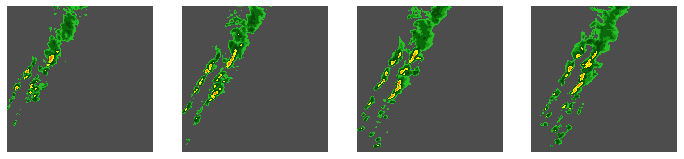

In [27]:
batch_index=1
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,4,figsize=(12,4))
for i in range(4):
    axs[i].imshow(X[batch_index,:,:,4*i],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) # every 4th frame
    axs[i].set_axis_off()

The variable `meta` contains additional information about the event pictured: 

In [33]:
meta.iloc[batch_index]

Unnamed: 0                                                    19989
id                                                          S819072
time_utc                                        2019-04-09 17:10:00
episode_id                                                   136472
event_id                                                     819072
event_type                                        Thunderstorm Wind
minute_offsets    -60:-55:-50:-45:-40:-35:-30:-25:-20:-15:-10:-5...
llcrnrlat                                                   41.4343
llcrnrlon                                                  -77.3679
urcrnrlat                                                    43.831
urcrnrlon                                                  -71.5107
proj              +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...
height_m                                                     384000
width_m                                                      384000
Name: 1, dtype: object

Since this event has an associated `event_id`, more information can be obtained from NCEI storm event database associated to the year of the event (2019 in this case).  Look for the files named `StormEvents_details` for the particular years of interest here: 

[https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles](https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles)

If you download relevant files, additional information for the event can be obtained by searching these files for the `episode_id` or `event_id` found in `meta`

In [37]:
!grep 136472 ../data/storm_events/StormEvents_details-ftp_v1.0_d2019_c20191217.csv

201904,9,1254,201904,9,1254,136472,819071,"NEW YORK",36,2019,"April","Hail","C",43,"HERKIMER","ALY","09-APR-19 12:54:00","EST-5","09-APR-19 12:54:00","0","0","0","0","0.00K","0.00K","Trained Spotter","0.75",,,,,,,,,,,"2","NNE","MILLERS MILLS","2","NNE","MILLERS MILLS","42.96","-75.06","42.96","-75.06","Strong winds developed ahead of a cold frontal boundary on Tuesday, April 9th, 2019. These strong winds resulted in trees being blown down in Albany county. As the cold front passed through the area late in the afternoon, strong thunderstorms developed, which resulted in additional reports of trees down and penny size hail.","","CSV"
201904,9,1310,201904,9,1310,136472,819072,"NEW YORK",36,2019,"April","Thunderstorm Wind","C",95,"SCHOHARIE","ALY","09-APR-19 13:10:00","EST-5","09-APR-19 13:10:00","0","0","0","0",,,"County Official","50.00","EG",,,,,,,,,,"0","N","COBLESKILL","0","N","COBLESKILL","42.67","-74.48","42.67","-74.48","Strong winds developed ahead of a cold frontal boundary on Tu

Some of the metadata can be used to georeference the patches shown above.  If cartopy is installed in your environment, map features can be added to these plots:

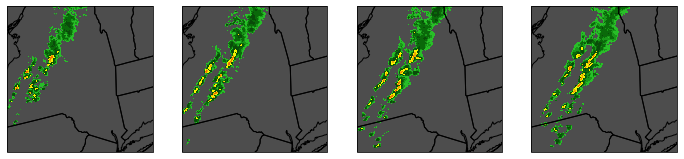

In [38]:
# REQUIRES CARTOPY (and an internet connection if this is your first time using cartopy)
proj,img_extent = make_ccrs(meta.iloc[batch_index])
xll,xur=img_extent[0],img_extent[1]
yll,yur=img_extent[2],img_extent[3]
fig,axs=plt.subplots(1,4,figsize=(12,4), subplot_kw={'projection':proj})
for i in range(4):
    axs[i].set_xlim((xll,xur))
    axs[i].set_ylim((yll,yur))
    axs[i].imshow(X[batch_index,:,:,4*i],interpolation='nearest',
                  origin='lower',transform=proj,extent=[xll,xur,yll,yur],
                  cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) # every 4th frame
    axs[i].add_feature(cfeature.STATES)


The function `make_animation` creates a short movie loop:

In [28]:
%%capture off 
anim = make_animation(X[batch_index],meta.iloc[batch_index],title='Inputs')
anim.save('imgs/input_animation.gif', writer='imagemagick', fps=6)
anim = make_animation(Y[batch_index],meta.iloc[batch_index],title='Target')
anim.save('imgs/output_animation.gif', writer='imagemagick', fps=6)

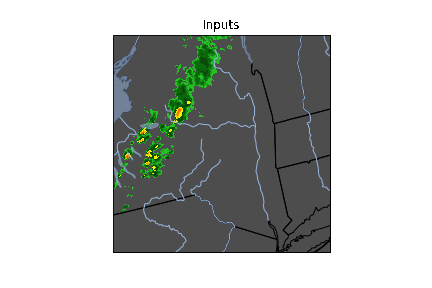

In [29]:
Image('imgs/input_animation.gif')

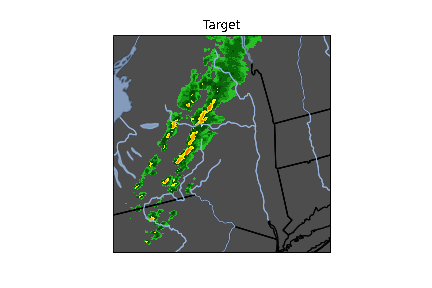

In [30]:
Image('imgs/output_animation.gif')

## Create baseline model<a class="anchor" id="baseline"></a>

In this section we'll initialize a baseline model and train it.

### Initialize U-Net model

The baseline model used in this notebook is the U-Net model based on the model described [here](https://proceedings.neurips.cc//paper/2020/hash/fa78a16157fed00d7a80515818432169-Abstract.html).

This model has the following structure, which takes a sequence of VIL images, and outputs another sequence that covers the next hour of time:
![imgs/unet.png](imgs/unet.png)

Code for the model is defined in `unet_benchmark.py`.  

The following cell defines training hyperparamters we'll use to start.  These can be adjusted as needed.

In [56]:
# Add more as needed
params={
    'start_neurons'   :16,      # Controls size of hidden layers in CNN, higher = more complexity 
    'activation'      :'relu',  # Activation used throughout the U-Net,  see https://www.tensorflow.org/api_docs/python/tf/keras/activations
    'loss'            :'mae',   # Either 'mae' or 'mse', or others as https://www.tensorflow.org/api_docs/python/tf/keras/losses
    'loss_weights'    :0.021,    # Scale for loss.  Recommend squaring this if using MSE
    'opt'             :tf.keras.optimizers.Adam,  # optimizer, see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    'learning_rate'   :0.001,   # Learning rate for optimizer
    'num_epochs'      :10,       # Number of epochs to train for
    'batch_size'      :8        # Size of batches during training
}

In [57]:
unet = create_model(start_neurons=params['start_neurons'],activation=params['activation']) 
unet.summary()

Model: "nowcast_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 384, 13 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 384, 384, 13) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 384, 384, 16) 1888        lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 384, 384, 16) 64          conv2d_18[0][0]                  
______________________________________________________________________________________

For a loss function, we'll start with mean absolute error scaled by an estimate of the standard deviation computed over the training data ($\sigma=47.54$)
\begin{equation}
L(Y,\hat{Y})=\frac{1}{\sigma}\sum_{i} ||Y-\hat{Y}||_1
\end{equation}

In [58]:
opt=params['opt'](learning_rate=params['learning_rate'])
unet.compile(optimizer=opt, loss=params['loss'],loss_weights=[params['loss_weights']])

### Train Model <a class="anchor" id="training"></a>

We'll set up two callbacks.  The first saves checkpoints whenever `val_loss` is minimized.  The other sets up tensorboard.

**NOTE:  Model checkpoints will be saved under the `experiments` directory in a newly created time-stamped directory.  A link named `experiments/latest` is also created that points to the most recent experiment.**


In [59]:
# Training 10 epochs takes around 10-20 minutes on GPU
num_epochs=params['num_epochs']
batch_size=params['batch_size']
exprmt_dir=make_log_dir('experiments')

callbacks=[
    tf.keras.callbacks.ModelCheckpoint(exprmt_dir+'/nowcast-unet-{epoch:04d}-{val_loss:04f}.hdf5', 
                    monitor='val_loss',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=exprmt_dir+'/tboardlogs')
]

history = unet.fit(x=X_train, y=Y_train,
                  batch_size=batch_size,
                  epochs=num_epochs,
                   callbacks=callbacks,
                  validation_data=(X_val, Y_val))

Train on 4070 samples, validate on 1018 samples
Epoch 1/10
4070/4070 [==============================] - 51s 12ms/sample - loss: 0.3427 - val_loss: 0.2813
Epoch 2/10
4070/4070 [==============================] - 48s 12ms/sample - loss: 0.2371 - val_loss: 0.2088
Epoch 3/10
4070/4070 [==============================] - 49s 12ms/sample - loss: 0.1992 - val_loss: 0.1843
Epoch 4/10
4070/4070 [==============================] - 48s 12ms/sample - loss: 0.1902 - val_loss: 0.1835
Epoch 5/10
4070/4070 [==============================] - 48s 12ms/sample - loss: 0.1812 - val_loss: 0.1813
Epoch 6/10
4070/4070 [==============================] - 48s 12ms/sample - loss: 0.1782 - val_loss: 0.1731
Epoch 7/10
4070/4070 [==============================] - 47s 12ms/sample - loss: 0.1739 - val_loss: 0.1971
Epoch 8/10
4070/4070 [==============================] - 48s 12ms/sample - loss: 0.1721 - val_loss: 0.1672
Epoch 9/10
4070/4070 [==============================] - 47s 12ms/sample - loss: 0.1671 - val_loss: 0.175

Plot model training performance for the first 10 epochs

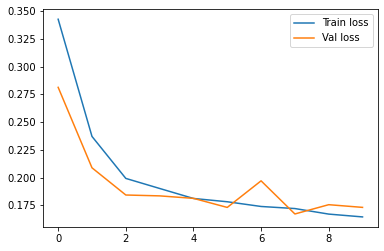

In [60]:
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Val loss')
plt.legend()

In [61]:
# save model for later use
unet.save('unet_10epochs.h5')

In [62]:
# Reload previously saved model
# Make sure to use `custom_objects` for custom loss functions

# NOTE: The best performing model (on val set) across all epochs was saved under experiments/latest, 
# so you can also load that instead

unet = tf.keras.models.load_model('unet_10epochs.h5',custom_objects={})

## Visualize model on test samples <a class="anchor" id="visualize"></a>

Start by visualizing the resulting model on test samples


In [110]:
batch_size,batch_num=8,4
bs,be=batch_size*batch_num,batch_size*(batch_num+1)
x_test,y_test,meta = X_test[bs:be],Y_test[bs:be],testing_meta.iloc[bs:be]

In [125]:
%%capture off 
bidx=5
anim = make_animation(x_test[bidx],meta.iloc[bidx],title='Inputs')
anim.save('imgs/input_test_animation.gif', writer='imagemagick', fps=6)
anim = make_animation(y_test[bidx],meta.iloc[bidx],title='Target')
anim.save('imgs/output_test_animation.gif', writer='imagemagick', fps=6)

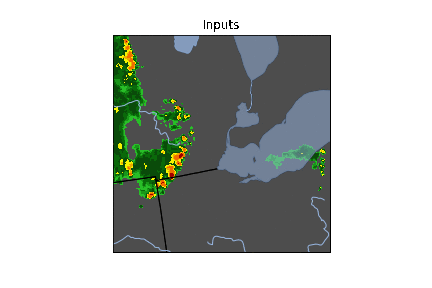

In [126]:
Image('imgs/input_test_animation.gif')

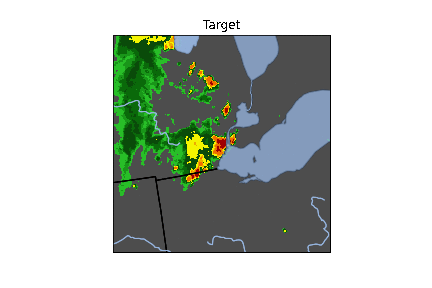

In [127]:
Image('imgs/output_test_animation.gif')

Now compute the prediction

In [128]:
%%capture off 
y_pred = unet.predict(x_test)
anim = make_animation(y_pred[bidx],meta.iloc[bidx],title='Prediction')
anim.save('imgs/pred_test_animation.gif', writer='imagemagick', fps=6)

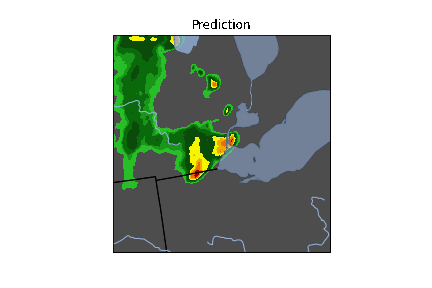

In [129]:
Image('imgs/pred_test_animation.gif')

What do you think?  You can adjust `batch_num` and `bidx` to view other cases from the test set.

The good:
* Seems to be moving the weather in the correct direction, and retaining some of the structure

The bad:
* A lot of the detail gets washed out, and for longer leads, the more intense sections of the storm decay.


## Forecast Scoring <a class="anchor" id="scoring"></a>

Let's apply some more quantitative verifications to establish baseline performance.  

To define metrics used, let $T_i(t)$ and $F_i(t)$ represent target and forecast images, respectively, for test sample $i$ at lead time $t=5,10,...,60$ minutes.  The first metric to consider is mean-absolute error (MAE): 

\begin{equation}
MAE(t) = \frac{1}{L^2 \sigma N_{test}}\sum_{i=1}^{N_{test}} ||T_i(t)-F_i(t)||_1 
\end{equation}

MAE is nice because it is simple, however it often fails to capture forecast skill in predicting fine detail in storm, such as severe storm cores.  Therefore, we'll also apply more standard forecast verification metrics (see [https://www.cawcr.gov.au/projects/verification/](https://www.cawcr.gov.au/projects/verification/)).

Given a threshold $\tau$, we binarize both the traget and forecast images, and label each pixel as a "hit" ($H$) if both target and forecast are $\geq \tau$, a "miss" ($M$) if $T\geq\tau$ and $F<\tau$, a "false alarm" ($FA$) if $T<\tau$ and $F\geq \tau$, and a correct rejection if both $T$ and $F$ are less than $\tau$. 

These pixel scores are rolled up into Critical Success Ratio (CSI) (which is the same as Intersection over Union, which is another common name for this metric) and is computed as 

\begin{equation}
CSI(t;\tau) = \frac{\#H}{\#H + \#M + \#FA}
\end{equation}

For scoring VIL nowcasts, we'll average this over three thresholds [16,74,133] representing low, medium, and high strom intensity.  We'll refer to this average as "mCSI", computed for each lead time $t$.

\begin{equation}
mCSI(t) = \frac{1}{3}(CSI(t;16) + CSI(t;74) + CSI(t;133))
\end{equation}

The "final" test scores can be computed by averaging $MAE$ and $mCSI$ over all lead times in 0-60 minutes.

This repo contains some code to compute CSI for the test set.


In [130]:
# Run unet over the test set
y_pred = unet.predict(X_test,batch_size=4)

In [141]:
# Compute metrics over the test set separately for each lead (takes a few minutes)
from tqdm import tqdm
from src.metrics import critical_success_index
CSI = lambda yt,yp,tau: critical_success_index(yt.astype(np.float32),
                                               yp.astype(np.float32),np.array([tau],dtype=np.float32)).numpy()

THRESHOLDS=np.array([16,74,133],dtype=np.float32)
nT=Y_test.shape[3]
mae_t=[]
csi_t = []
for t in tqdm(range(nT)):
    mae_t.append(np.mean(tf.keras.losses.MAE(Y_test[:,:,:,t:t+1],y_pred[:,:,:,t:t+1])))
    csi_t.append(np.mean([CSI(Y_test[:,:,:,t:t+1], y_pred[:,:,:,t:t+1],tau) for tau in THRESHOLDS]))
    

100%|██████████| 12/12 [02:29<00:00, 12.44s/it]


We'll also include another standard baseline model in nowcasting, the *persistence model*.  This model represents the "do nothing" forecast where the last image in the input sequence is just repeated for every future frame.

In [142]:
# Also compute scores of persistence model
nT=Y_test.shape[3]
pers_mae_t=[]
pers_csi_t = []
for t in tqdm(range(nT)):
    pers_mae_t.append(np.mean(tf.keras.losses.MAE(Y_test[:,:,:,t:t+1],X_test[:,:,:,-1:].astype(np.float32))))
    pers_csi_t.append(np.mean([CSI(Y_test[:,:,:,t:t+1], X_test[:,:,:,-1:],tau) for tau in THRESHOLDS]))

100%|██████████| 12/12 [01:55<00:00,  9.64s/it]


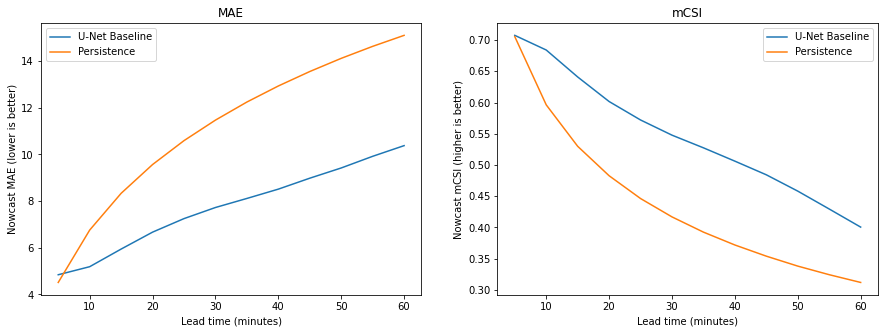

Average MAE of U-Net:  7.7460675
Average mCSI of U-Net:  0.54665816


In [147]:
t=np.arange(5,65,5)
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(t,mae_t,label='U-Net Baseline')
ax[0].plot(t,pers_mae_t,label='Persistence')
ax[0].set_xlabel('Lead time (minutes)')
ax[0].set_ylabel('Nowcast MAE (lower is better)')
ax[0].set_title('MAE')
ax[0].legend()

ax[1].plot(t,csi_t,label='U-Net Baseline')
ax[1].plot(t,pers_csi_t,label='Persistence')
ax[1].set_xlabel('Lead time (minutes)')
ax[1].set_ylabel('Nowcast mCSI (higher is better)')
ax[1].set_title('mCSI')
ax[1].legend()
plt.show()

print('Average MAE of U-Net on test set: ',np.mean(mae_t))
print('Average mCSI of U-Net on test set: ',np.mean(csi_t))


The baseline model beats persistence (phew!) but it can still be better!  

##### Can you create a model that improves upon the above test scores?

## (Optiona) Applying to full images <a class="anchor" id="fullimgs"></a>

The model trained above is fully convolutional and can be apllied to full-sized radar mosaics.  Sample US radar mosaics of VIL can be obtained from the MRMS system [https://mrms.ncep.noaa.gov/data/2D/VIL/](https://mrms.ncep.noaa.gov/data/2D/VIL/).  The past 24 hours of files are avaialble online for download.  The model *may* also work for other radar fields, e.g. reflectivity, so long as they are first normalized to the range [0-255] first.

The MRMS files are in `grib2` format and needs to be converted to a numpy array and converted to the [0-255] scale used to train the model above.   [This gist](https://gist.github.com/markveillette/048d7e6b6be35d26bac37378bd66ae01) provides a script for doing this conversion.  MRMS data is not a part of this repo so you'll need to go prepare the data yourself.


In [93]:
# pick 13 sample files which are 4 minutes apart (SEVIR is 5 minutes apart, close enough)
mrms_root='/home/gridsan/mveillette/data/MRMS/npy'
# UPDATE WITH YOUR OWN FILES
files=[
    'MRMS_CONUS_VIL_00.50_20201125-160039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-160436.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-161039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-161442.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-162039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-162434.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-163037.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-163436.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-164041.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-164438.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-165039.grib2.npy','MRMS_CONUS_VIL_00.50_20201125-165436.grib2.npy',
    'MRMS_CONUS_VIL_00.50_20201125-170042.grib2.npy']
vil=[]
for f in files:
    vil.append(np.load(mrms_root+'/'+f)[np.newaxis,:,:,np.newaxis])
vil=np.concatenate(vil,axis=3)
vil = np.pad(vil, ((0,0),(2,2),(4,4),(0,0))) # needed to make sure downsample layers can be done cleanly
m=vil[0:1,2:-2,4:-4,0]==255
vil[vil==255]=0

In [150]:
# Load weights of your own saved model, but make sure input_shape is None so it works on full sized images
unet = create_model(start_neurons=params['start_neurons'],
                    activation=params['activation'],input_shape=(None,None,13))
unet.load_weights('experiments/unet_baseline/nowcast-unet-0039-0.133934.hdf5')

In [116]:
# If this overwhelms your GPU, you might need to compute forecast in smaller subsections
forecast = unet.predict(vil)

In [117]:
%%capture off 
import cartopy.crs as crs
from cartopy.crs import Globe
import cartopy.feature as cfeature
from matplotlib import animation, rc
def make_mrms_animation(frames,img_type='vil',fig=None,
                   interval=100,title=None,**kwargs):
    """
    Makes animation of MRMS data
    """
    ellps='WGS84'
    globe=Globe(ellipse=ellps)
    proj=crs.PlateCarree(globe=globe)
    img_extent=(-14471586.0, -6679194.0322265625, 2226397.75, 6122594.1611328125) # MRMS extent
    xll,xur=img_extent[0],img_extent[1]
    yll,yur=img_extent[2],img_extent[3]
    if fig is None:
        fig=plt.gcf()
    ax=fig.add_subplot(1,1,1,projection=proj)
    ax.set_xlim((xll,xur))
    ax.set_ylim((yll,yur))
    cmap,norm,vmin,vmax=get_cmap(img_type)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS )
    
    im=ax.imshow(frames[:,:,0], interpolation='nearest',
          origin='upper', extent=[xll,xur,yll,yur],
          transform=proj,cmap=cmap,norm=norm,vmin=vmin,vmax=vmax);

    def init():
        return (im,)
    def animate(i):
        im.set_data(frames[:,:,i]);
        ftype='Analysis' if i<13 else 'Forecast'
        ax.set_title(ftype)
        return (im,)
    return animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=range(frames.shape[2]), 
                                   interval=interval, blit=True);

frames = np.concatenate((vil[:,2:-2,4:-4,:],forecast[:,2:-2,4:-4,:]),axis=3)
for i in range(frames.shape[3]):
    frames[:,:,:,i][m]=np.nan
plt.figure(figsize=(15,7))
anim = make_mrms_animation(frames[0])
anim.save('imgs/mrms_animation.gif', writer='imagemagick', fps=6)

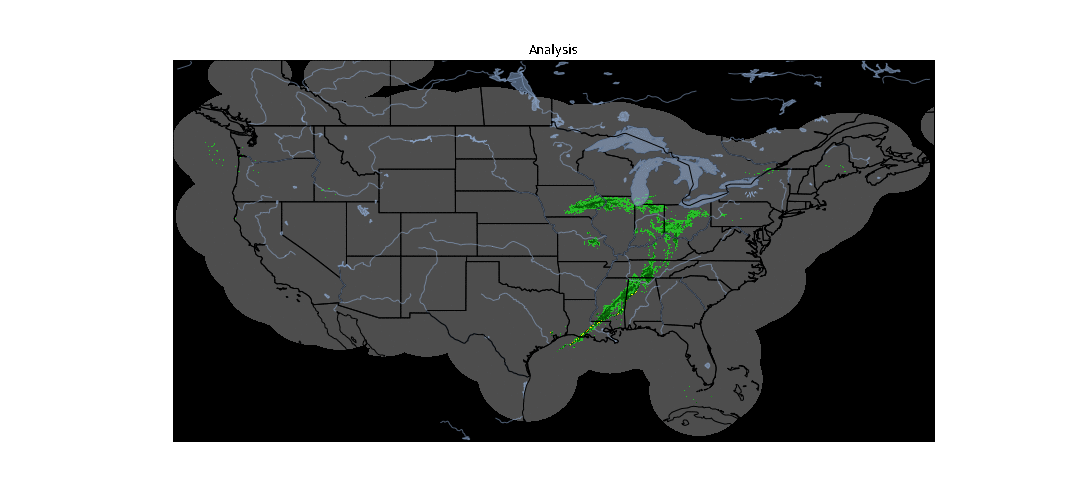

In [118]:
Image('imgs/mrms_animation.gif')